In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
tf.test.is_gpu_available()

True

In [3]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

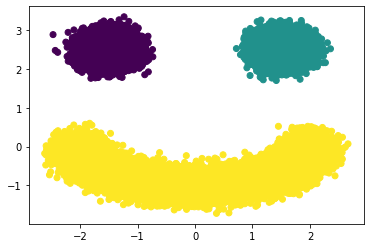

In [4]:
X, Y = sample_data()
X_train, Y_train = X[:80000,:], Y[:80000]
X_test, Y_test = X[-20000:,:], Y[-20000:]
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)

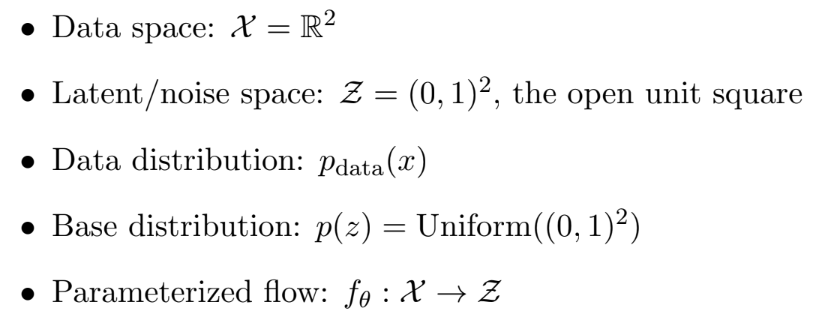

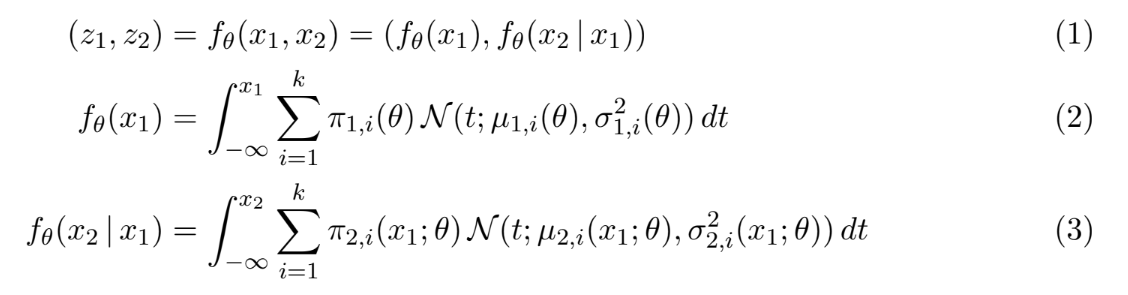

In [5]:
def dense_masked(x, nrof_units, mask, activation=None):
    nrof_inputs = x.get_shape()[1]
    kernel = tf.get_variable('kernel', shape=(nrof_inputs, nrof_units), dtype=tf.float32, 
        initializer=tf.initializers.glorot_normal, trainable=True)
    bias = tf.get_variable('bias', shape=(nrof_units,), dtype=tf.float32, 
        initializer=tf.initializers.zeros, trainable=True)
    y = tf.tensordot(x, kernel*mask, 1) + bias
    y = activation(y) if activation else y
    return y
    
def get_masks(nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins):
        
    m = []
    m0 = np.repeat(np.arange(nrof_dims), nrof_bins)
    m += [ m0 ]
    for i in range(nrof_layers):
        rep = int(np.ceil(nrof_units/((nrof_dims-1))))
        mx = np.repeat(np.arange(nrof_dims-1), rep)[:nrof_units]
        m += [ mx ]
        
    mask = []
    for i in range(len(m)-1):
        msk = m[i+1][:,None] >= m[i][None,:]
        cx = np.ones((msk.shape[0], nrof_aux))
        msk2 = np.concatenate((cx, msk), axis=1)
        mask += [ msk2.T ]
    msk = m0[:,None] > m[-1][None,:]
    cx = np.ones((msk.shape[0], nrof_aux))
    msk2 = np.concatenate((cx, msk), axis=1)
    mask += [ msk2.T ]
        
    return mask

def made(x, aux, nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins):
    x = tf.cast(x, tf.float32)
    masks = get_masks(nrof_units, nrof_layers, nrof_dims, nrof_aux, nrof_bins)
    hidden = [nrof_units]*nrof_layers+[nrof_dims*nrof_bins]
    for i, h in enumerate(hidden):
        with tf.compat.v1.variable_scope('made_%d' % i):
            activation = tf.nn.relu if i<nrof_layers else None
            x = dense_masked(x, h, masks[i], activation=activation)
    return x

def softlimit(x, limit=0.1):
    return tf.math.log(tf.math.exp(x) + 1.0 + limit)

W1013 22:09:18.512205 139643820492608 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1013 22:09:18.612818 139643820492608 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train epoch: 5  loss: 1.093
train epoch: 10  loss: 1.102
train epoch: 15  loss: 1.101
train epoch: 20  loss: 1.099
Test NLL: 1.115 bits/dim


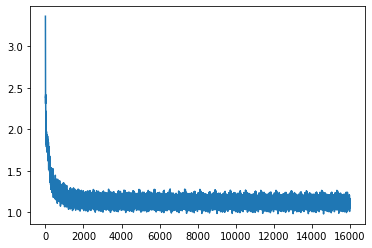

In [6]:
tf.reset_default_graph()
with tf.Graph().as_default():

    batch_size=100
    nrof_units=100
    nrof_layers=4
    nrof_dims=2
    nrof_mixtures=5
    nrof_epochs=20
    x_ph = tf.placeholder(tf.float32, shape=(None, nrof_dims))
    x = tf.reshape(tf.tile(x_ph[:,:,None], [1,1,3*nrof_mixtures]), [-1, nrof_dims*nrof_mixtures*3])
    y = made(x, aux=None, nrof_units=nrof_units, nrof_layers=nrof_layers,
             nrof_dims=nrof_dims, nrof_aux=0, nrof_bins=3*nrof_mixtures)
    z_pi, z_mu, z_sigma = tf.unstack(tf.reshape(y, (-1, nrof_dims, nrof_mixtures, 3)), num=None, axis=3)
    pi = tf.nn.softmax(z_pi, axis=-1)
    mu = z_mu
    sigma = softlimit(z_sigma)
    
    dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=pi),
        components_distribution=tfd.Normal(loc=mu, scale=sigma))
    log_prob = tf.reduce_mean(dist.log_prob(x_ph), axis=1)
    prob = tf.math.exp(log_prob)
    nll = -tf.reduce_mean(log_prob)
    z = dist.cdf(x_ph)
    sample = dist.sample()
    
    loss = nll
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

    nrof_train_batches = int(np.floor(X_train.shape[0] / batch_size))
    train_loss_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            _, loss_ = sess.run([train_op, loss], feed_dict={x_ph: x_batch})
            train_loss_list += [ loss_ ]
        
        if epoch % 5 == 0:
            print('train epoch: %d  loss: %.3f' % (epoch, loss_))
    test_loss_ = sess.run(loss, feed_dict={x_ph: X_test})
    print('Test NLL: %.3f bits/dim' % (test_loss_))
    
    plt.plot(train_loss_list)


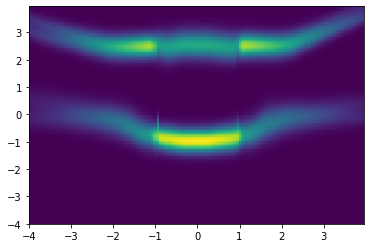

In [7]:
# Learned density
x_grid = np.arange(-4, 4, 0.05)
y_grid = np.arange(-4, 4, 0.05)
x1, x2 = np.meshgrid(x_grid, y_grid)
X_mesh = np.vstack([x1.flatten(),x2.flatten()]).T
prob_ = sess.run(prob, feed_dict={x_ph: X_mesh})
sz = int(np.sqrt(prob_.shape[0]))
_ = plt.pcolormesh(x_grid, y_grid, np.reshape(prob_, (sz,sz)))

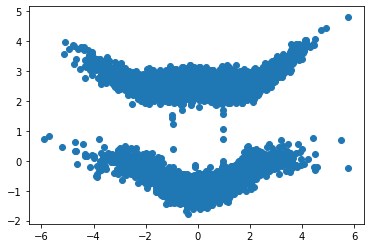

In [9]:
# Draw samples
samples = np.zeros((10000,2))
samp1_ = sess.run(sample, feed_dict={x_ph: samples})
samples[:,0] = samp1_[:,0]
samp2_ = sess.run(sample, feed_dict={x_ph: samples})
samples[:,1] = samp2_[:,1]
plt.scatter(samples[:,0], samples[:,1])

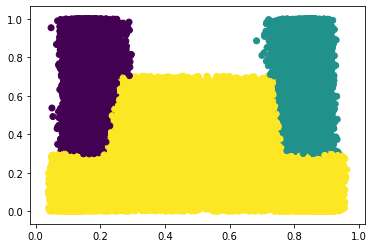

In [10]:
# Latent space
z_ = sess.run(z, feed_dict={x_ph: X_train[:60000,:]})
plt.scatter(z_[:,0], z_[:,1], c=Y_train[:60000])